# Grain boundaries of $\alpha$-Fe tutorial
Berlin, 2017 - Adam Fekete, Martina Stella, Henry Lambert, Alessandro De Vita, Gabor Csanyi

## Introduction

In this tutorial we will be using a machine learning method (clustering) to analyse results of Grain Boundary (GB) calculations of $\alpha$-iron. Along the way we will learn about different methods to describe local atomic environment in order to calculate properties of GBs. We will use these properties to separate the different regions of the GB using clustering methods. Finally we will determine how the energy of the GB is changing according to the angle difference of the regions.

### Tutorial overview:

1. [The data (Nomad, Imeall)](#The-data)
2. [Analysis of the data - Definition of Local Atomic Enviroment](#2.-Analysis-of-the-data---Definition-of-Local-Atomic-Enviroment)
    1. [coordination number](#Coordination-Numbers)
    2. [centrosymmetry parameter analysis](#Centrosymmetry-parameter-analysis)
    3. [polyhedral template matching](#Polyhedral-Template-Matching)
3. [Machine Learning methods: Clustering](#3.-Machine-Learning-methods:--Clustering)



## 1.  A look at the data: Grain boundaries

Grain boundaries are 2D defects in the crystal structure, studying them is important because they can change the mechanical, electrical and thermal properties of the material. GBs can also play a significant role in how metals  break or become brittle and fracture due to the introduction and subsequent diffusion of hydrogen into the metal.

Mainly there are two types of GBs; the schematic below represents a tilt (top) and a twist (bottom) boundary between two idealised grains.
<img align="center" width="30%" src="https://upload.wikimedia.org/wikipedia/commons/9/96/TiltAndTwistBoundaries_remade.svg">


### The data

NOMAD is co-developing the Imeall set of tools for addressing the atomistic properties of GBs in metals, starting from bcc Fe. The atomistic GB structures will be stored in the NOMAD archive, the users will be able to define and mount a desired database subset, index its structures, and perform extended analysis of grain properties.

In this tutorial we will use a tiny subset of the full database. All the calculations of this subset are **relaxed structures of tilt GBs**, calculated using **PotHB potential** and stored in **extended xyz** file format.

The database is still in development - special thanks to *Dr Henry Lambert* - and its size is continuously growing (currently $\approx$ 1.6 TB). We can browse all currently accessible data on the following link:<br>
  https://labdev-nomad.esc.rzg.mpg.de/industry-project-imeall/



***

First we need to load the python packages that we use in this notebook.

In [1]:
%matplotlib inline

from __future__ import print_function
import sys
sys.path.append("/data/shared/afekete/tutorial/")

from os import listdir
from pathlib import Path

import numpy as np

from ase import Atoms
from ase.io import read


from ase.visualize import view
from ase.visualize.plot import plot_atoms

from scripts.Visualise import AtomViewer

import matplotlib.pyplot as plt

from asap3 import FullNeighborList
from asap3.analysis import CoordinationNumbers, FullCNA, PTM

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

Define some parameters of alpha-Fe (BCC):

In [2]:
# potential energy of the perfect crystal according to a specific potential
Fe_BCC_energy_per_atom = -4.01298214176 # alpha-Fe PotBH
Fe_BCC_lattice_constant = 2.856


List the first 10 files in the directory of tilt GB

In [3]:
dir_path = Path("/data/shared/afekete/tutorial/data/GB_alphaFe_001/tilt")
listdir(str(dir_path))[:10], 'etc.'

(['00134715160_v6bxv2_tv0.2bxv0.4_d1.4z_traj.xyz',
  '00150037150_v6bxv2_tv0.0bxv0.2_d1.5z_traj.xyz',
  '00148895110_v6bxv2_tv0.4bxv0.2_d1.6z_traj.xyz',
  '00195301120_v6bxv2_tv0.4bxv0.3_d1.9z_traj.xyz',
  '00130513110_v6bxv2_tv0.1bxv0.1_d1.6z_traj.xyz',
  '00178589110_v6bxv2_tv0.3bxv0.2_d1.4z_traj.xyz',
  '001818313150_v6bxv2_tv0.2bxv0.5_d2.0z_traj.xyz',
  '001854212130_v6bxv2_tv0.3bxv0.4_d1.4z_traj.xyz',
  '001860514150_v6bxv2_tv0.2bxv0.3_d1.4z_traj.xyz',
  '0011626170_v6bxv2_tv0.3bxv0.4_d1.9z_traj.xyz'],
 'etc.')

Load a selected calculation using ase.io.read function into an ase.Atoms object which contains the properties of the calculation and the list of atoms.
You can choose any of them.

In [4]:
# filepath = dir_path / '0012807140_v6bxv2_tv0.4bxv0.0_d1.8z_traj.xyz'
filepath = dir_path / '0016193350_v6bxv2_tv0.4bxv0.4_d2.0z_traj.xyz'
atoms = read(str(filepath))

We can use the help function, or "?" mark to get more details about attributes and methods of the ase.Atoms object:

In [5]:
# help(Atoms)
?Atoms

Print some properties of the calculation:

In [6]:
print('number of atoms: {:d}\n'.format(atoms.get_number_of_atoms()),
      'total_energy: {:.4f} eV\n'.format(atoms.get_total_energy()),
      'cell voluem:  {:.4f} A^3\n'.format(atoms.get_volume()),
      'periodic boundary: {}'.format(atoms.get_pbc()))

number of atoms: 3120
 total_energy: -12440.8626 eV
 cell voluem:  35708.0400 A^3
 periodic boundary: [ True  True  True]


We can calculate the GB's energy as the energy difference between the perfect crystal and the actual calculation diveded by the area of the GB


In [7]:
def gb_energy(total_energy, n_atoms, area):
    
    eV = 1.6021766208e-19
    Angstrom = 1.e-10

    return 1 / (2 * area * Angstrom**2) * \
        (total_energy - Fe_BCC_energy_per_atom * n_atoms) * eV


cell = atoms.get_cell_lengths_and_angles()
area = cell[0] * cell[1]

E_gb = gb_energy(atoms.get_total_energy(), len(atoms), area)

print('energy of grain boundary: {:.4f} J/m^2\n'.format(E_gb),
      'area: {:.4f} A^2'.format(area))

energy of grain boundary: 1.1385 J/m^2
 area: 560.3941 A^2


Let's visualise the atomic structure. AtomViewer is capable of visualising ase.Atoms object in jupyter notebook environment. We can also represent each atom with a different colour


In [9]:
# view(atoms, viewer='ngl')

atom_index = range(len(atoms))
view = AtomViewer(atoms, atom_index)
view.gui

A Jupyter Widget

## 2. Analysis of the data - Definition of Local Atomic Enviroment

In this part we will see methods for describing the local atomic environment (LEA) based on the atomic coordinates only. Later we will use these LAE parameters to construct the feature space for clustering. Most of the methods are invariant under translation and rotation. Usually this is useful, but we will see that in our tutorial we need to use orientation information for proper clustering. 

Methods:
1. [coordination number](#Coordination-Numbers)
2. [centrosymmetry parameter analysis](#Centrosymmetry-parameter-analysis)
3. [polyhedral template matching](#Polyhedral-Template-Matching)

You can find more details about each method at the end of the tutorial.

### Coordination Numbers

The coordination number of an atom is the number of its nearest neighbor atoms. In a realistic system, it is not necessarily well defined if two atoms are nearest neighbors, so the coordination number is defined as the number of neighbors within a certain distance.

**Task:**

- Try to use different values for cutoff radius.
- Find a reasonable value for cutoff radious.<br>
  *Hint: optimal value should be between the first and second shell*<br>
  $\frac{\sqrt{3}}{2} \alpha < r_{cut} < \alpha$, <br>
  - where $\alpha$ is the lattice constant.

In [10]:
?CoordinationNumbers

In [11]:
coord_num = CoordinationNumbers(atoms, rCut=0.93*Fe_BCC_lattice_constant)    

Below you can find th python implementation of the CN method:

In [12]:
?FullNeighborList

In [13]:
nblist = FullNeighborList(0.93*Fe_BCC_lattice_constant, atoms=atoms)

coord_num = np.zeros(len(atoms))
for i, (atom, neighbor) in enumerate(zip(atoms, nblist)):
    coord_num[i] = len(neighbor)
    

Let's visualise the result! On the following histogram we can see that most atoms have the same amount of neighbors.

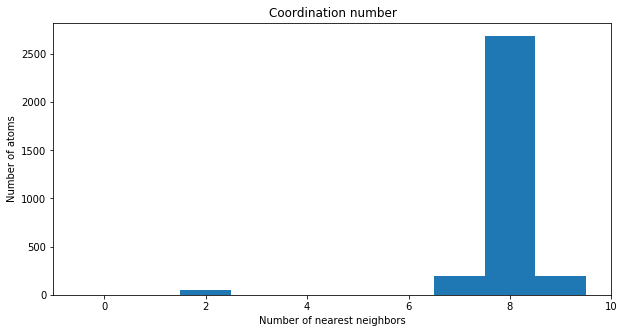

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

bins = np.arange(-0.5, max(coord_num) + 1)
ax.hist(coord_num, bins)

ax.set_title('Coordination number')
ax.set_xlabel("Number of nearest neighbors")
ax.set_ylabel("Number of atoms")
plt.show()

We can visualise indiviual values. Here the colour represents the number of neighbors for each atom.

In [16]:
view = AtomViewer(atoms, coord_num)
view.gui

A Jupyter Widget

We can see that the value of the coordination number is capable of identifying the grain boundary, but is highly sensitive to the chosen cutoff radius.

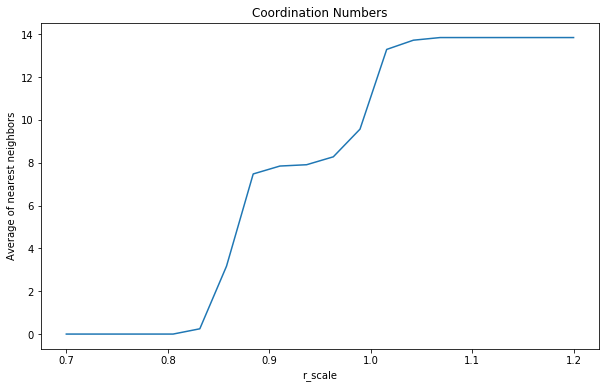

In [17]:
r_scale_list = np.linspace(0.7, 1.2, 20)

avg_neihbour = []
for r_scale in r_scale_list:
    coord_num = CoordinationNumbers(atoms=atoms, rCut=r_scale * Fe_BCC_lattice_constant)
    avg_neihbour.append(np.average(coord_num))
    
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(r_scale_list, avg_neihbour)
ax.set_xlabel("r_scale")
ax.set_ylabel("Average of nearest neighbors")
ax.set_title("Coordination Numbers")
plt.show()

### Centrosymmetry parameter analysis

The centrosymmetry property of some lattices (e.g. fcc and bcc) can be used to
distinguish them from other structures such as crystal defects where the local bond
symmetry is broken. The CSP of an atom having N nearest neighbors is defined as
$$CPS = \sum\limits_{i=1}^{N/2} \left| \mathbf{r_i} + \mathbf{r}_{i+N/2}\right|^2$$
- where $\mathbf{r}_i$ and $\mathbf{r}_{i+N/2}$ are vectors from the central atom to a pair of opposite neighbors.


You can find a practical implementation below. For BCC structure we need to use the 8 nearest neighbor.

In [18]:
from scipy.spatial import cKDTree

def CentroSymmentryParameter(atoms, n):
    
    atoms.wrap()
    coordinates = atoms.get_positions()
    box = np.diag(atoms.get_cell())
    
    # Building the nearest neighbor list
    
    nblist = cKDTree(coordinates, boxsize=np.hstack([box, np.zeros_like(box)]))     # boxsize needs to be 2*dim but neglected
    distances, nblist = nblist.query(coordinates, k=n+1)

    
    csp=np.zeros(len(atoms))
    for neighbors in nblist:
        atom_index = neighbors[0]
        n_indecies = neighbors[1:]
        N = len(n_indecies)
        
        r = atoms[n_indecies].get_positions() - atoms[atom_index].position
        
        # fixing periodic boundary 
        r = np.where(abs(r) < abs(r - box), r, r - box)
        r = np.where(abs(r) < abs(r + box), r, r + box)
 
        pairs = []
        for i, r_i in enumerate(r):
            pairs.append(np.linalg.norm(r_i + r[i+1:,:], axis=1))

        pairs = np.hstack(pairs)

        pairs.sort()
        csp[atom_index] = np.sum(pairs[:N//2])

    return csp

csp = CentroSymmentryParameter(atoms, n=8)

The result show how symmetric is the LOA - 0 means perfectly symmetric.

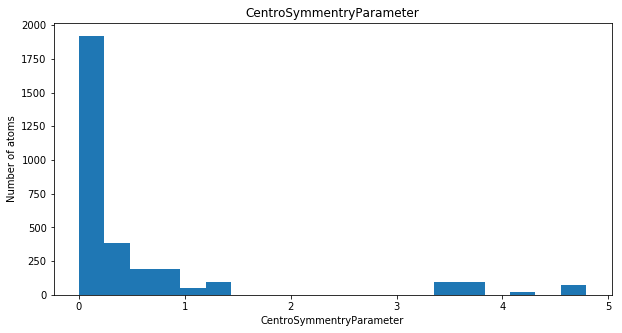

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

ax.hist(csp, bins=20)

ax.set_title('CentroSymmentryParameter')
ax.set_xlabel("CentroSymmentryParameter")
ax.set_ylabel("Number of atoms")
# ax.set_yscale('symlog')

plt.show()

In [20]:
view = AtomViewer(atoms, csp)
view.gui

A Jupyter Widget

### Polyhedral Template Matching

Polyhedral Template Matching (PTM) is a new alternative to the popular Common Neigbor Analysis, providing raughly the same advantages, but with a greater robustness against thermal vibrations, and does not depend critically on a cutoff.

The PTM classifies the local crystalline order, and identifies local simple cubic (SC), face-centered cubic (FCC), body-centered cubic (FCC), hexagonal closed-packed (HCP) and icosahedral (ICO) order. In addition, some ordered alloys based on the FCC and BCC structures are also detected, namely L1_0, L1_2 and B2 structures.

https://wiki.fysik.dtu.dk/asap/Local%20crystalline%20order#polyhedral-template-matching-ptm

In [21]:
# help(PTM)
# Imprtant key names of returned data: 
# 'structure': The local crystal structure around atom i, if any. 
#              0 = none; 1 = FCC; 2 = HCP; 3 = BCC; 4 = Icosahedral; 5 = SC.
# 'rmsd': The RMSD error in the fitting to the template, or INF if no structure was identified.
# 'scale': The average distance to the nearest neighbors for structures 1-4; 
#          or the average distance to nearest and next-nearest neighbors for structure 5; 
#          or INF if no structure was identified.
# 'orientation': The orientation of the crystal lattice, expressed as a unit quaternion. 
#                If no structure was found, the illegal value (0, 0, 0, 0) is returned.

?PTM

In [22]:
ptm = PTM(atoms=atoms, cutoff=8.)
ptm.keys()

['info',
 'distance',
 'scale',
 'orientation',
 'rmsd',
 'latticeconstant',
 'alloytype',
 'structure']

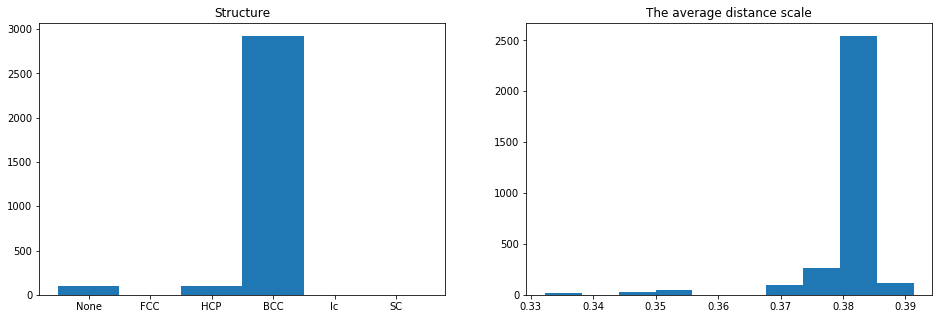

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.hist(ptm['structure'], range(0, 7))
# ax1.set_yscale('symlog')
ax1.set_xticks([x + .5 for x in range(6)])
ax1.set_xticklabels(['None', 'FCC', 'HCP', 'BCC', 'Ic', 'SC'])
ax1.set_title('Structure')

ax2.hist(ptm['scale'])
# ax2.set_yscale('symlog')
ax2.set_title('The average distance scale')


plt.show()


In [24]:
view = AtomViewer(atoms, ptm['structure'])

view.view.center()
view.gui

A Jupyter Widget

## 3. Machine Learning methods:  Clustering

Clustering - grouping a set of objects - is an unsupervised machine learning problem. Like for most machine learning algorithms, finding the proper features is one of the most important tasks.
We can find a summary about the clustering methods below:

http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

<img align="left" width="90%" src="http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png">



Let's design the feature space for clustering. Here we can use the following local properties for constructing the feature space: 
    - coord_num
    - csp
    - ptm['orientation']
    - ptm['scale']
    - ptm['rmsd']
    - ptm['structure']
    
We can also define which clustering method we want to use:
    - pred = KMeans(n_clusters=n_clusters).fit_predict(X)
    - pred = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(X).predict(X)

In [25]:
?KMeans

In [26]:
?GaussianMixture

In [28]:
# Feature space
X = np.hstack([ptm['scale'][:, np.newaxis], csp[:, np.newaxis]])
X = np.hstack([ptm['orientation'], csp[:, np.newaxis]])
# X = ptm['orientation']

# Number of clusters
n_clusters=10

# Clusterring method
pred = KMeans(n_clusters=n_clusters).fit_predict(X)
# pred = GaussianMixture(n_components=n_clusters, covariance_type='full').fit(X).predict(X)


Our goal is to find two groups / the two largest groups of atoms after clustering. We can validate the results by checking the histogram of the prediction. We can see that we must use the descriptor which contains information about the local crystal orientation.

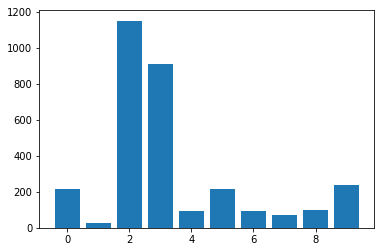

In [29]:
count = np.bincount(pred)
plt.bar(range(n_clusters),count)
plt.show()

By visualising the results, we can see which atoms belong together.

In [30]:
view = AtomViewer(atoms, pred)

view.view.center()
view.gui

A Jupyter Widget

We can use the two largest cluster for calculating the avarage angle difference between the grains.

In [ ]:
# select the 2 largest
index = np.argsort(count)[-2:]
orientation0 = np.average(ptm['orientation'][pred==index[0], :], axis=0)
orientation1 = np.average(ptm['orientation'][pred==index[1], :], axis=0)

angle_difference = 2 * np.arccos(np.dot(orientation0, np.conj(orientation1)))*180/np.pi

print('The angle difference between the grains is: {:.3f} degree'.format(angle_difference))

# Finally: 

We can construct a function and run it on all available data to show how the GB energy changes by changing the angle of the grains:

In [ ]:
def diff_angle(filepath):
    atoms = read(str(filepath))
    
    cell = atoms.get_cell_lengths_and_angles()
    area = cell[0] * cell[1]

    E_gb = gb_energy(atoms.get_total_energy(), len(atoms), area)

    ptm = PTM(atoms=atoms, cutoff=8.)

    X = ptm['orientation']
#     X = np.hstack([ptm['orientation'], ptm['scale'][:, np.newaxis]])
    
    n_clusters=20

    pred = KMeans(n_clusters=n_clusters).fit_predict(X)
    
    count = np.bincount(pred)
    index = np.argsort(count)[-2:]
    
    orientation0 = np.average(ptm['orientation'][pred==index[0], :], axis=0)
    orientation1 = np.average(ptm['orientation'][pred==index[1], :], axis=0)

    angle_difference = 2 * np.arccos(np.dot(orientation0, np.conj(orientation1)))*180/np.pi

    return angle_difference, E_gb

In [ ]:
filelist = list(dir_path.glob('**/*.xyz'))
result = np.zeros((len(filelist), 2))
for i, file in enumerate(filelist):
    print(str(file))
    result[i,:] = np.array(diff_angle(file))
    print(result[i,:])

Using the calculated angle difference we can show how the boundary energy change:

In [ ]:
result_sorted = result[result[:,0].argsort(),:]
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(result_sorted[:,0], result_sorted[:,1], 'o-')
plt.show()

## Take home massage:

- machine learning methods are useful tools to analyse datasets without any a priori information.
- we need to find the proper features for a certain application (choosing the right properties (features) is more important than the machine learning method itself)

## I hope you enjoyed this tutorial.

### Future readings:
- Rosenbrock, Conrad W., et al. "Discovering the Building Blocks of Atomic Systems using Machine Learning." arXiv preprint arXiv:1703.06236 (2017).
- Stukowski, Alexander. "Structure identification methods for atomistic simulations of crystalline materials." Modelling and Simulation in Materials Science and Engineering 20.4 (2012): 045021.
- Larsen, Peter Mahler, Søren Schmidt, and Jakob Schiøtz. "Robust structural identification via polyhedral template matching." Modelling and Simulation in Materials Science and Engineering 24.5 (2016): 055007.

### Sources:
- Ovito Open Visualization Tool: http://ovito.org/
- Visualisation: NglView (http://nglviewer.org/nglview/latest/api.html)